<a href="https://colab.research.google.com/github/ImNotDanish05/2025_Visi-Komputer_TI-2A/blob/main/Tugas02_KLASIFIKASI-GAMBAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By: ImNotDanish05

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


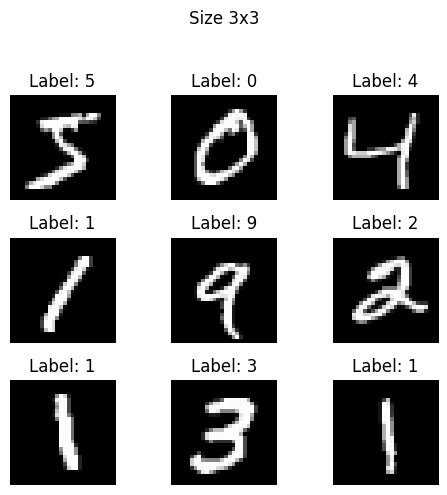

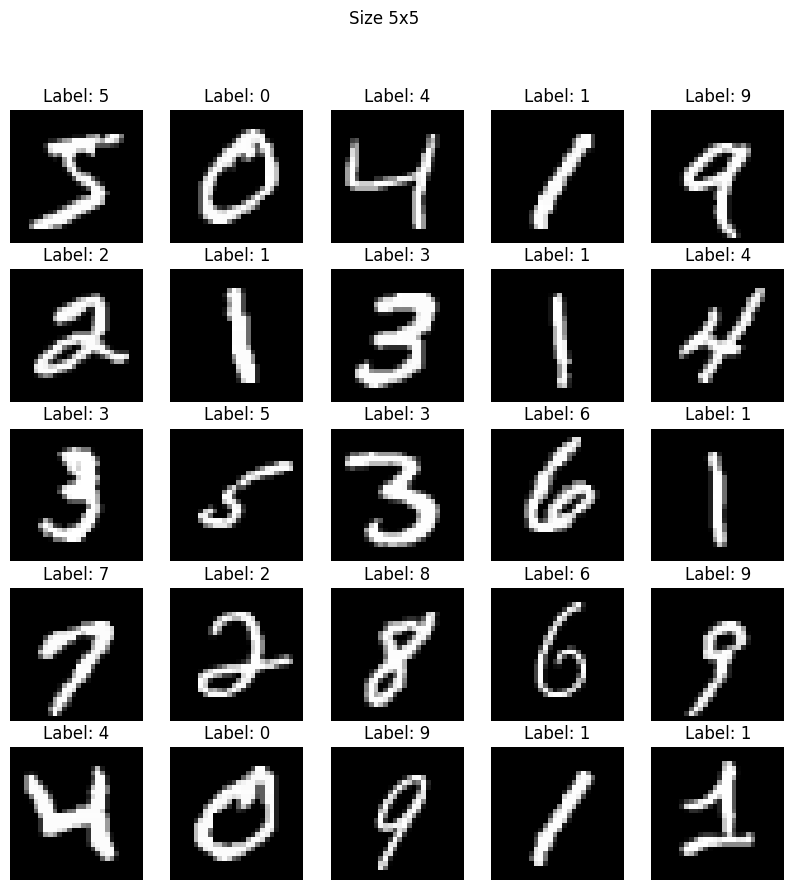

In [1]:
# @title 1. Ngeload data MNIST
# Load package
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

plt.figure(figsize=(5,5))
plt.suptitle("Size 3x3")
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


plt.figure(figsize=(10,10))
plt.suptitle("Size 5x5")
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

## 📋 Model yang rekomendasi

Berikut 4 base\_model yang bagus sebagai starting point:

1. **MobileNetV2**
   Ringan, performanya cukup bagus, cepat training dibanding model besar.

2. **EfficientNetB0**
   Lebih efisien (parameter vs akurasi bagus), cocok yang pengen balance.

3. **ResNet50V2**
   Lebih kompleks, bisa capture fitur lebih dalam.

4. **DenseNet121**
   Juga bagus menangkap fitur, skip connections, biasanya menghindari overfitting sedikit lebih baik.

Sumber: https://keras.io/api/applications/

In [2]:
# @title Model CNN
import tensorflow as tf
from tensorflow.keras import layers, models

x_train_cnn = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test_cnn = x_test.reshape(-1, 28, 28, 1) / 255.0

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])



model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
              )

history = model.fit(x_train_cnn, y_train, epochs=5, validation_split=0.1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 53s 29ms/step - accuracy: 0.8913 - loss: 0.3479 - val_accuracy: 0.9845 - val_loss: 0.0561
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 50s 30ms/step - accuracy: 0.9824 - loss: 0.0576 - val_accuracy: 0.9867 - val_loss: 0.0475
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 79s 28ms/step - accuracy: 0.9881 - loss: 0.0362 - val_accuracy: 0.9862 - val_loss: 0.0447
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9925 - loss: 0.0243 - val_accuracy: 0.9892 - val_loss: 0.0388
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9935 - loss: 0.0189 - val_accuracy: 0.9890 - val_loss: 0.0403


In [3]:
# @title SVM
from sklearn import svm
from sklearn.metrics import accuracy_score

# Flatten data dari 2D jadi 1D Vektor
x_train_flatten = x_train.reshape(len(x_train), -1) / 255.0
x_test_flatten = x_test.reshape(len(x_test), -1) / 255.0

# Training Model
clf = svm.SVC(kernel='rbf', gamma='scale') # RBF

# Gunakan subset karena SVM berat :)
# Batasi masing2 hanya 5000
clf.fit(x_train_flatten[:5000], y_train[:5000])

y_pred = clf.predict(x_test_flatten)

print("Akurasi RBF: ", accuracy_score(y_test, y_pred))

Akurasi RBF:  0.9513


In [4]:
# ===== 2) Utilitas Preprocess agar mirip MNIST (28x28, putih-di-atas-hitam) =====
import numpy as np
import cv2
import requests
import os
from PIL import Image, ImageEnhance, ImageOps

def preprocess_to_mnist_28x28(img_pil):
    """
    - Preprocess ke format MNIST (28x28) dengan connected components filtering
    - Return:
        disp = image (PIL.Image) siap ditampilkan
        arr  = numpy array (28,28,1) float [0,1]
    """

    # Grayscale
    img = img_pil.convert('L')

    # Tingkatkan kontras dulu
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(2.0)

    # Autocontrast biar range optimal
    img = ImageOps.autocontrast(img)

    arr = np.array(img).astype(np.uint8)

    # Invert bila background terang
    median_val = np.median(arr)
    if median_val > 127:
        img = ImageOps.invert(img)
        arr = np.array(img)

    # PERBAIKAN: Gunakan connected components untuk filter area yang relevan
    # Threshold untuk mendapatkan binary image
    thr = max(arr.max() * 0.5, 50)  # threshold dinamis
    binary = (arr > thr).astype(np.uint8) * 255

    # Gunakan connected components untuk mencari area terpisah
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

    # Filter components berdasarkan ukuran dan aspek ratio
    valid_components = []

    for i in range(1, num_labels):  # skip background (label 0)
        x, y, w, h, area = stats[i]

        # Filter berdasarkan ukuran (buang yang terlalu kecil atau terlalu besar)
        if area < 50 or area > arr.shape[0] * arr.shape[1] * 0.3:  # max 30% dari total image
            continue

        # Filter berdasarkan aspek ratio (digit biasanya tidak terlalu extreme)
        aspect_ratio = max(w, h) / min(w, h)
        if aspect_ratio > 5:  # skip area yang terlalu pipih/tinggi
            continue

        # Filter berdasarkan posisi (skip area di pinggir image)
        margin = 10
        if (x < margin or y < margin or
            x + w > arr.shape[1] - margin or
            y + h > arr.shape[0] - margin):
            # Cek apakah ini benar-benar di pinggir atau hanya dekat pinggir
            if (x == 0 or y == 0 or
                x + w == arr.shape[1] or
                y + h == arr.shape[0]):
                continue

        valid_components.append((i, area, x, y, w, h))

    if not valid_components:
        print("No valid components found, using largest component")
        # Fallback: ambil component terbesar (selain background)
        largest_idx = np.argmax(stats[1:, 4]) + 1
        x, y, w, h, area = stats[largest_idx]
    else:
        # Ambil component dengan area terbesar dari yang valid
        valid_components.sort(key=lambda x: x[1], reverse=True)
        largest_component = valid_components[0]
        idx, area, x, y, w, h = largest_component
        print(f"Selected component: area={area}, bbox=({x},{y},{w},{h})")

    # Crop ke area component yang dipilih dengan padding
    padding = 5
    x0 = max(0, x - padding)
    y0 = max(0, y - padding)
    x1 = min(arr.shape[1], x + w + padding)
    y1 = min(arr.shape[0], y + h + padding)

    img = img.crop((x0, y0, x1, y1))
    print(f"Final crop: ({x0}, {y0}, {x1}, {y1})")

    # Resize ke 20x20 dengan aspect ratio
    img.thumbnail((20, 20), Image.Resampling.LANCZOS)
    w, h = img.size

    # Pad ke 28x28
    canvas = Image.new('L', (28, 28), color=0)
    canvas.paste(img, ((28 - w) // 2, (28 - h) // 2))

    # Simpan untuk display
    disp = canvas.copy()

    # Normalisasi ke [0,1]
    arr = np.array(canvas).astype('float32') / 255.0
    arr = arr[..., np.newaxis]   # (28,28,1)

    return disp, arr

def create_super_contrast_image(image_path, output_path, contrast_factor=3.0):
    """
    Create clean high contrast version of image
    """
    # Buka image
    img = Image.open(image_path)

    # Convert ke grayscale dulu kalau belum
    if img.mode != 'L':
        img = img.convert('L')

    # Convert ke array untuk processing
    arr = np.array(img).astype(float)

    # Deteksi apakah background terang atau gelap
    # Cek pixel di corner untuk estimasi background
    corners = [arr[0,0], arr[0,-1], arr[-1,0], arr[-1,-1]]
    bg_estimate = np.mean(corners)

    # Jika background terang (>127), invert dulu
    if bg_estimate > 127:
        arr = 255 - arr

    # Tingkatkan contrast dengan lebih hati-hati
    # Normalize ke [0,1], apply contrast, lalu kembali ke [0,255]
    arr_norm = arr / 255.0
    arr_contrast = np.clip(((arr_norm - 0.5) * contrast_factor + 0.5), 0, 1)
    arr_contrast = (arr_contrast * 255).astype(np.uint8)

    # Gunakan simple threshold berdasarkan histogram
    # Cari threshold yang memisahkan dua mode terbesar
    hist, bins = np.histogram(arr_contrast.flatten(), bins=50)

    # Cari valley (lembah) antara dua peak
    # Ini lebih reliable daripada percentile
    from scipy.signal import find_peaks

    # Cari peaks dalam histogram
    peaks, _ = find_peaks(hist, height=np.max(hist)*0.1)

    if len(peaks) >= 2:
        # Ada dua peak, cari valley di antara mereka
        peak1, peak2 = peaks[0], peaks[-1]
        if peak1 > peak2:
            peak1, peak2 = peak2, peak1

        # Cari minimum antara dua peak
        valley_region = hist[peak1:peak2+1]
        if len(valley_region) > 0:
            valley_idx = np.argmin(valley_region) + peak1
            threshold = bins[valley_idx]
        else:
            threshold = np.mean(arr_contrast)
    else:
        # Fallback: gunakan Otsu-like method sederhana
        threshold = np.mean(arr_contrast)

    print(f"Using threshold: {threshold:.1f}")

    # Apply threshold
    arr_binary = np.where(arr_contrast > threshold, 255, 0).astype(np.uint8)

    # Simple noise cleanup - remove very small components
    try:
        import cv2
        # Remove small noise dengan area opening
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
        arr_binary = cv2.morphologyEx(arr_binary, cv2.MORPH_OPEN, kernel)
    except ImportError:
        pass  # Skip cleanup jika tidak ada OpenCV

    img_final = Image.fromarray(arr_binary)

    # Simpan
    img_final.save(output_path)
    return img_final

In [5]:
# @title 2. Mendowload image testing
import requests
import os

# URL API untuk folder target
url = "https://api.github.com/repos/ImNotDanish05/2025_Visi-Komputer_TI-2A/contents/Asset02_KLASIFIKASI-GAMBAR"

# Folder lokal tempat simpan file
save_dir = "Data_Original"
contrast_dir = "Data"  # Folder baru untuk high contrast images

# Buat kedua folder
os.makedirs(save_dir, exist_ok=True)
os.makedirs(contrast_dir, exist_ok=True)

# Get JSON list isi folder
response = requests.get(url)
files = response.json()

# Loop download tiap file
for file in files:
    if file["type"] == "file":  # pastikan itu file, bukan folder
        download_url = file["download_url"]
        file_name = os.path.join(save_dir, file["name"])
        contrast_file_name = os.path.join(contrast_dir, f"contrast_{file['name']}")

        print(f"Downloading {file['name']} ...")
        file_content = requests.get(download_url).content

        # Simpan file asli
        with open(file_name, "wb") as f:
            f.write(file_content)

        # Cek apakah ini file gambar
        if file["name"].lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            print(f"Creating high contrast version of {file['name']} ...")
            try:
                create_super_contrast_image(file_name, contrast_file_name, contrast_factor=5.0)
                print(f"✅ High contrast version saved: {contrast_file_name}")
            except Exception as e:
                print(f"❌ Error processing {file['name']}: {str(e)}")

print("✅ Semua file berhasil di-download dan diproses!")
print(f"📁 Original images: {save_dir}/")
print(f"📁 High contrast images: {contrast_dir}/")


Creating high contrast version of test1_image.png ...
Using threshold: 16.8
✅ High contrast version saved: Data/contrast_test1_image.png
Creating high contrast version of test2_image.png ...
Using threshold: 16.2
✅ High contrast version saved: Data/contrast_test2_image.png
Creating high contrast version of test3_image.png ...
Using threshold: 16.7
✅ High contrast version saved: Data/contrast_test3_image.png
✅ Semua file berhasil di-download dan diproses!
📁 Original images: Data_Original/
📁 High contrast images: Data/


Selected component: area=33398, bbox=(74,283,297,467)
Final crop: (69, 278, 376, 755)


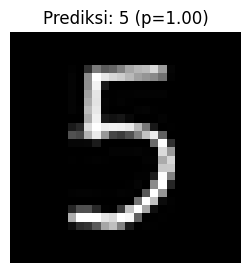

Selected component: area=35222, bbox=(51,249,353,517)
Final crop: (46, 244, 409, 771)


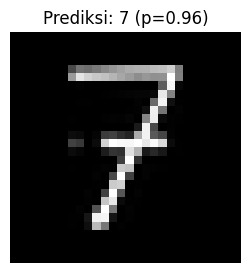

Selected component: area=33140, bbox=(71,255,320,457)
Final crop: (66, 250, 396, 717)


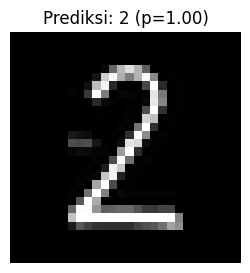

Rekap Prediksi (CNN):
- contrast_test3_image.png -> 5 (p=0.998)
- contrast_test1_image.png -> 7 (p=0.958)
- contrast_test2_image.png -> 2 (p=1.000)


In [6]:
import os
import matplotlib.pyplot as plt

results = []

# Folder berisi gambar
folder_path = "Data"
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Loop tiap file di folder
for fname in image_files:
    img_path = os.path.join(folder_path, fname)
    img_pil = Image.open(img_path)

    # Preprocessing ke format MNIST
    disp, x = preprocess_to_mnist_28x28(img_pil)   # disp = buat ditampilkan, x = array (28,28,1)

    # Siapkan batch (1 sample)
    x_batch = np.expand_dims(x, axis=0)

    # Prediksi pakai model
    probs = model.predict(x_batch, verbose=0)[0]
    pred = int(np.argmax(probs))
    conf = float(np.max(probs))

    results.append((fname, pred, conf))

    # Tampilkan hasil prediksi untuk gambar
    plt.figure(figsize=(3, 3))
    plt.imshow(disp, cmap='gray')
    plt.title(f"Prediksi: {pred} (p={conf:.2f})")
    plt.axis('off')
    plt.show()

# Rekap ringkas
print("Rekap Prediksi (CNN):")
for r in results:
    print(f"- {r[0]} -> {r[1]} (p={r[2]:.3f})")

In [7]:
import os
from sklearn.metrics import accuracy_score

results = []

# Folder berisi gambar
folder_path = "Data"
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Loop tiap file di folder
for fname in image_files:
    img_path = os.path.join(folder_path, fname)
    img_pil = Image.open(img_path)

    # Preprocessing ke format MNIST (28x28, float [0,1])
    _, x = preprocess_to_mnist_28x28(img_pil)
    x_flat = x.reshape(1, -1)   # (1, 784)

    # Prediksi dengan SVM
    pred = int(clf.predict(x_flat)[0])

    # Coba ambil probabilitas (jika model dilatih dengan probability=True)
    conf = None
    try:
        if hasattr(clf, "predict_proba"):
            conf = float(np.max(clf.predict_proba(x_flat)))
    except Exception:
        pass

    results.append((fname, pred, conf))

    # Tampilkan hasil
    if conf is not None:
        print(f"{fname} -> Prediksi SVM: {pred} (p≈{conf:.2f})")
    else:
        print(f"{fname} -> Prediksi SVM: {pred}")

# Ringkasan hasil
print("\nRekap Prediksi (SVM):")
for r in results:
    print(f"- {r[0]} -> {r[1]}" + (f" (p≈{r[2]:.3f})" if r[2] is not None else ""))

Selected component: area=33398, bbox=(74,283,297,467)
Final crop: (69, 278, 376, 755)
contrast_test3_image.png -> Prediksi SVM: 5
Selected component: area=35222, bbox=(51,249,353,517)
Final crop: (46, 244, 409, 771)
contrast_test1_image.png -> Prediksi SVM: 1
Selected component: area=33140, bbox=(71,255,320,457)
Final crop: (66, 250, 396, 717)
contrast_test2_image.png -> Prediksi SVM: 2

Rekap Prediksi (SVM):
- contrast_test3_image.png -> 5
- contrast_test1_image.png -> 1
- contrast_test2_image.png -> 2
